<h1>Capstone Project - The Battle of Neighborhoods | Finding a better place in Bangalore India</h1>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

The purpose of this Project is to help people in exploring better facilities around their neighborhood. It will help people making smart and efficient decision on selecting great neighborhood out of numbers of other neighborhoods in Bangalore, India.

Lots of people are migrating from various states of India and needed lots of research for good house rental prices and reputated schools for their children. This project is for those people who are looking for better neighborhoods. For ease of accessing to Cafe, School, Super market, medical shops, grocery shops, mall, theatre, hospital, like minded people, etc.

This Project aim to create an analysis of features for people migrating to Bangalore to search a best neighborhood as a comparative analysis between neighborhoods.

It will help people to get an idea of the area and neighborhood before moving to a new city, state, country or place for their work or to start a new fresh life.

## 2. Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* Schools with good ratings
* House Rental prices
* Ease of access to essential shops

Following data sources will be needed to extract/generate the required information:
* Neighborhood data scraped from https://www.mapsofindia.com/pincode/india/karnataka/bangalore/ using **Beautiful Soup Python Package**
* Neighborhoods will be generated algorithmically and approximate location of those areas will be obtained using **Geocoder Python package**
*  Venues in every neighborhood will be obtained using **Foursquare API**
* The data retrieved from **Foursquare API** contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

    1. Neighborhood
    2. Neighborhood Latitude
    3. Neighborhood Longitude
    4. Venue
    5. Name of the venue e.g. the name of a store or restaurant
    6. Venue Latitude
    7. Venue Longitude
    8. Venue Category

<h3>1 : Installing and importing Python Libraries and dependencies</h3>

In [235]:
# !conda install -c conda-forge geopy --yes
!pip install geocoder

Importing Libraries

In [236]:
import requests 
import pandas as pd
import numpy as np
import folium
import geocoder
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

## 3. Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Bangalore that have the best neighborhoods for people migrating from other places.

In first step we will collect the required data using **Beautiful Soup Library** and clean the data. We will also obtained the location of each neighborhood using **Geocoder Python package**

Second step in our analysis will be getting the venues within a radius of 500 meters of each neighborhood using **Foursquare API** and explatory analysis one hot encoding and grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category will be performed to get the Top 10 most common venues of each neighborhood and to get  a better understanding of the dataset. 

In third step we will focus on clustering the neighborhoods using **k-means clustering**.We will present map of all the neighborhoods of Bangalore City and visualize to see the simillar neighborhood clusters. We will also examine each of the clusters and determine the most common types of venues present in the neighborhoods.

In the fourth and final step we will analyze neighborhoods and clusters based on the Average School Ratings and Average House Rental Prices which will also affect the decision making process.

<h3>3.1 Data Extraction and Cleaning</h3>

Using BeautifulSoup for scraping List of Postal Codes

In [237]:
url = "https://www.mapsofindia.com/pincode/india/karnataka/bangalore/"
text_data = requests.get(url).text
wiki_data = BeautifulSoup(text_data, 'lxml')

Converting content of HTML table to DataFrame

In [238]:
column_names = ['Neighborhood','Postalcode','State','Borough']
bangalore = pd.DataFrame(columns = column_names)

neighborhood = 0
postcode = 0
state = 0
borough = 0

table = wiki_data.find('table')

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            neighborhood = td.text
            i = i + 1
        elif i == 1:
            postcode = td.text
            i = i + 1
        elif i == 2:
            state = td.text
            i = i + 1
        elif i == 3:
            borough = td.text
    bangalore = bangalore.append({'Neighborhood': neighborhood,'Postalcode': postcode,'State':state,'Borough': borough},ignore_index=True)

Cleaning Dataframe

In [241]:
bangalore.head()

,Neighborhood,Postalcode,State,Borough
0,0,0,0,0
1,Location,Pincode,State,District
2,A F station yelahanka,560063,Karnataka,Bangalore
3,Adugodi,560030,Karnataka,Bangalore
4,Agara,560034,Karnataka,Bangalore


In [242]:
# Cleaning Dataframe
bangalore.drop([0,1], inplace = True)
bangalore.drop(columns=['State'], inplace = True)
bangalore.reset_index(drop=True).head()

,Neighborhood,Postalcode,Borough
0,A F station yelahanka,560063,Bangalore
1,Adugodi,560030,Bangalore
2,Agara,560034,Bangalore
3,Agram,560007,Bangalore
4,Air Force hospital,560007,Bangalore


In [243]:
bangalore.describe()

,Neighborhood,Postalcode,Borough
count,294,294,294
unique,294,99,1
top,Shanthinagar,562106,Bangalore
freq,1,13,294


In [244]:
# Grouping and merging neighborhoods of similar postal code
bangalore = bangalore.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()

delete below if not required

In [9]:
# Further processing the data
bangalore.drop([4,10,97,98],inplace = True)

# Size of the Dataframe
print(bangalore.shape)

(95, 3)


<h3>Function for getting the co-ordinates of neighborhoods</h3>

In [246]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Bangalore, Karnataka'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

In [247]:
# Retrieving Postal Code Co-ordinates
postal_codes = bangalore['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [334]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
bangalore['Latitude'] = df_coords['Latitude']
bangalore['Longitude'] = df_coords['Longitude']
#bangalore.dropna(inplace=True)
#bangalore.reset_index(drop=True)
bangalore.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,560001,Bangalore,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",12.979185,77.606623
1,560002,Bangalore,"Avenue Road, Bangalore City, Bangalore Corpora...",12.964070,77.577647
2,560003,Bangalore,"Aranya Bhavan, Malleswaram, Palace Guttahalli,...",13.003656,77.569745
3,560004,Bangalore,"Basavanagudi, Lalbagh West, Mavalli, Pasmpamah...",12.945664,77.575075
4,560005,Bangalore,"Fraser Town, Jeevanahalli",12.998115,77.620842


In [249]:
# address of Bangalore Karnataka
address = 'Bangalore, Karnataka'

geolocator = Nominatim(user_agent="bangalore_explorer")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Bangalore, Karnataka are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Bangalore, Karnataka are 12.9791198, 77.5912997.


<h3>Map of Bangalore City</h3>

In [250]:
map_bangalore = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, neigh in zip(bangalore['Latitude'], bangalore['Longitude'], bangalore['Neighborhood']):
    
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangalore)  
    
map_bangalore

<h3>3.2 Using the Foursquare API to explore the neighborhoods and segment them</h3>

Hide the client secretkey

In [2]:
# @hidden cell
CLIENT_ID = '2I5ARXKRW03W2DVYNPF0A5IM0WHL3JE1HBJCZ5ZJQ5FYVRZR' # my Foursquare ID
CLIENT_SECRET = 'S2OAU2KFIJA3JLJKHNM5FO2YFYUSGNEMERBY3CHZP1EHUKHW' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2I5ARXKRW03W2DVYNPF0A5IM0WHL3JE1HBJCZ5ZJQ5FYVRZR
CLIENT_SECRET:S2OAU2KFIJA3JLJKHNM5FO2YFYUSGNEMERBY3CHZP1EHUKHW


<h3>Function to find venues</h3>

In [252]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [254]:
# venues in bangaore city
bangalore_venues = getNearbyVenues(names=bangalore['Neighborhood'],
                                   latitudes=bangalore['Latitude'],
                                   longitudes=bangalore['Longitude']
                                  )

Bangalore Bazaar, Bangalore., Brigade Road, Cubban Road, Dr. ambedkar veedhi, Highcourt, Legislators Home, Mahatma Gandhi road, Narayan Pillai street, Rajbhavan, Vidhana Soudha
Avenue Road, Bangalore City, Bangalore Corporation building, Bangalore Fort, Basavaraja Market, Cahmrajendrapet, Narasimjharaja Road, New Tharaggupet, Sri Jayachamarajendra road
Aranya Bhavan, Malleswaram, Palace Guttahalli, Swimming Pool extn, Venkatarangapura, Vyalikaval Extn
Basavanagudi, Lalbagh West, Mavalli, Pasmpamahakavi Road, Shankarpura, Visveswarapuram
Fraser Town, Jeevanahalli
J.C.nagar, Training Command iaf
Agram, Air Force hospital
H.A.l ii stage, Hulsur Bazaar, Someswarapura
Bangalore Dist offices bldg, K. g. road, Subhashnagar
Bhashyam Circle, Industrial Estate, Rajajinagar, Rajajinagar I block, Rajajinagar Ivth block
Jayangar Iii block, Madhavan Park
Science Institute
Govindapalya, H M t, Jalahalli, Jalahalli Village
Jalahalli East
Jalahalli West, Kamagondanahalli
Doorvaninagar, Krishnarajapuram

<h3>Size of the resulting venues DataFrame</h3>

In [255]:
print(bangalore_venues.shape)
bangalore_venues.head()

(741, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",12.979185,77.606623,Peppa Zzing,12.979700,77.605907,Burger Joint
1,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",12.979185,77.606623,Samarkand,12.980616,77.604668,Afghan Restaurant
2,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",12.979185,77.606623,Unicorn Bar and Restaurant,12.979790,77.605710,Bar
3,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",12.979185,77.606623,M.G Road Boulevard,12.975771,77.603979,Plaza
4,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",12.979185,77.606623,The 13th Floor,12.975364,77.604995,Lounge


<h3>Number of venues returned for each neighborhood</h3>

In [256]:
bangalore_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
A F station yelahanka,1,1,1,1,1,1
"Adugodi, Hosur Road",6,6,6,6,6,6
"Agara, Kendriya Sadan, Koramangala, Koramangala I block, St. john's medical college",21,21,21,21,21,21
"Agram, Air Force hospital",3,3,3,3,3,3
"Amruthahalli, Kodigehalli, Sahakaranagar P.o",9,9,9,9,9,9
"Anandnagar, H.A. farm, Hebbal Kempapura",11,11,11,11,11,11
"Arabic College, Devarjeevanahalli, Nagavara, Ramakrishna Hegde nagar, Venkateshapura",5,5,5,5,5,5
"Aranya Bhavan, Malleswaram, Palace Guttahalli, Swimming Pool extn, Venkatarangapura, Vyalikaval Extn",13,13,13,13,13,13
"Ashoknagar, Banashankari, Dasarahalli, State Bank of mysore colony",1,1,1,1,1,1


<h3>Number of unique venue categories curated from all the returned venues</h3>

In [257]:
print('There are {} uniques categories.'.format(len(bangalore_venues['Venue Category'].unique())))

There are 152 uniques categories.


<h3>Explatory data analysis</h3>

<h4>Analyze each neighborhoods</h4> 

In [258]:
# one hot encoding
bangalore_onehot = pd.get_dummies(bangalore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangalore_onehot['Neighborhood'] = bangalore_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bangalore_onehot.columns[-1]] + list(bangalore_onehot.columns[:-1])
bangalore_onehot = bangalore_onehot[fixed_columns]

bangalore_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Tea Room,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store,Yoga Studio
0,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Size of the DataFrame

In [259]:
bangalore_onehot.shape

(741, 153)

<h3>Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category</h3>

In [265]:
bangalore_grouped = bangalore_onehot.groupby('Neighborhood').mean().reset_index()
bangalore_grouped.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Tea Room,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store,Yoga Studio
0,A F station yelahanka,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Adugodi, Hosur Road",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Agara, Kendriya Sadan, Koramangala, Koramangal...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Agram, Air Force hospital",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Amruthahalli, Kodigehalli, Sahakaranagar P.o",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>Function to sort venues in descending order</h3>

In [266]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<h3>Creating the new dataframe and display the top 10 venues for each neighborhood.</h3>

In [294]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_grouped['Neighborhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A F station yelahanka,ATM,Department Store,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop,Diner,Dessert Shop,Design Studio,Cupcake Shop
1,"Adugodi, Hosur Road",Fast Food Restaurant,Restaurant,Bus Station,Indian Restaurant,Furniture / Home Store,Design Studio,Department Store,Dumpling Restaurant,Donut Shop,Diner
2,"Agara, Kendriya Sadan, Koramangala, Koramangal...",Indian Restaurant,Café,Department Store,Burger Joint,Italian Restaurant,Bar,Bakery,Beer Garden,Brewery,Ice Cream Shop
3,"Agram, Air Force hospital",ATM,Department Store,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop,Diner,Dessert Shop,Design Studio,Cupcake Shop
4,"Amruthahalli, Kodigehalli, Sahakaranagar P.o",Indian Restaurant,Fast Food Restaurant,Pharmacy,Ice Cream Shop,Pizza Place,Brewery,Bubble Tea Shop,Yoga Studio,Department Store,Donut Shop


<h3>3.3 Clustering Neighbourhoods</h3>

k-means to cluster the neighborhood into 5 clusters

In [295]:
# set number of clusters
kclusters = 4

bangalore_grouped_clustering = bangalore_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 3, 0, 2, 0, 3, 2, 3, 3, 2])

<h3>Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.</h3>

In [296]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangalore_merged = bangalore

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bangalore_merged = bangalore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
bangalore_merged.dropna(inplace=True)
bangalore_merged.reset_index(drop=True)
bangalore_merged = bangalore_merged.astype({'Cluster Labels': int})

bangalore_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,560001,Bangalore,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",12.979185,77.606623,3,Indian Restaurant,Clothing Store,Lounge,Fast Food Restaurant,Bar,Hotel,Women's Store,Café,Men's Store,American Restaurant
1,560002,Bangalore,"Avenue Road, Bangalore City, Bangalore Corpora...",12.964070,77.577647,3,Historic Site,Diner,Market,South Indian Restaurant,Miscellaneous Shop,Plaza,Cupcake Shop,Donut Shop,Dessert Shop,Design Studio
2,560003,Bangalore,"Aranya Bhavan, Malleswaram, Palace Guttahalli,...",13.003656,77.569745,3,Coffee Shop,Ice Cream Shop,Indian Restaurant,South Indian Restaurant,Camera Store,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Chinese Restaurant,Donut Shop,Flea Market
3,560004,Bangalore,"Basavanagudi, Lalbagh West, Mavalli, Pasmpamah...",12.945664,77.575075,0,Indian Restaurant,Bakery,Fast Food Restaurant,Farmers Market,Sandwich Place,Dessert Shop,Mediterranean Restaurant,Snack Place,Metro Station,Food Truck
4,560005,Bangalore,"Fraser Town, Jeevanahalli",12.998115,77.620842,0,Indian Restaurant,Chinese Restaurant,Shopping Mall,Café,Movie Theater,Intersection,Yoga Studio,Department Store,Dumpling Restaurant,Donut Shop


<h3>Visualize the resulting clusters</h3>

In [298]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bangalore_merged['Latitude'], bangalore_merged['Longitude'], bangalore_merged['Neighborhood'], bangalore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3>Examining Clusters</h3>

<h3>Cluster 0</h3>

In [299]:
cluster0 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 0, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

In [300]:
print('The size of Cluster0 is',cluster0.shape)
cluster0.head()

The size of Cluster0 is (30, 12)


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bangalore,0,Indian Restaurant,Bakery,Fast Food Restaurant,Farmers Market,Sandwich Place,Dessert Shop,Mediterranean Restaurant,Snack Place,Metro Station,Food Truck
4,Bangalore,0,Indian Restaurant,Chinese Restaurant,Shopping Mall,Café,Movie Theater,Intersection,Yoga Studio,Department Store,Dumpling Restaurant,Donut Shop
8,Bangalore,0,Indian Restaurant,Hotel,Bed & Breakfast,Bus Station,Dessert Shop,Seafood Restaurant,Shopping Mall,Park,Diner,Asian Restaurant
9,Bangalore,0,Indian Restaurant,Vegetarian / Vegan Restaurant,Café,Gym,Restaurant,Fast Food Restaurant,Juice Bar,Lounge,Grocery Store,Convenience Store
10,Bangalore,0,Gym Pool,Vegetarian / Vegan Restaurant,Indian Restaurant,Fast Food Restaurant,Cocktail Bar,Design Studio,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop


Count of the most common venues in cluster0

In [301]:
cluster0 = cluster0.iloc[:,2:]

In [302]:
for key, value in cluster0.iteritems(): 
    print(key)
    print(value.value_counts().idxmax() , str(value.value_counts().max()))
    print()   

1st Most Common Venue
Indian Restaurant 23

2nd Most Common Venue
Café 4

3rd Most Common Venue
Café 4

4th Most Common Venue
Fast Food Restaurant 3

5th Most Common Venue
Yoga Studio 4

6th Most Common Venue
Design Studio 4

7th Most Common Venue
Donut Shop 4

8th Most Common Venue
Dumpling Restaurant 5

9th Most Common Venue
Donut Shop 5

10th Most Common Venue
Donut Shop 7



<h4>From above observation we can say that out of 30 neighborhoods in Cluster 0, 23 neighborhoods has 1st most common venues as "Indian Restaurant"</h4>

<h3>Cluster 1</h3>

In [303]:
cluster1 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 1, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

In [304]:
print('The size of Cluster1 is',cluster1.shape)
cluster1

The size of Cluster1 is (1, 12)


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
86,Bangalore,1,Diner,Yoga Studio,Department Store,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop,Dessert Shop,Design Studio,Cupcake Shop


<h4>From above data we can say that the most common venues in Cluster 1 is "Diner"</h4>

<h3>CLuster 2</h3>

In [305]:
cluster2 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 2, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

In [306]:
print('The size of Cluster2 is',cluster2.shape)
cluster2.head()

The size of Cluster2 is (6, 12)


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Bangalore,2,ATM,Department Store,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop,Diner,Dessert Shop,Design Studio,Cupcake Shop
41,Bangalore,2,ATM,Clothing Store,Food Truck,Department Store,Electronics Store,Dumpling Restaurant,Donut Shop,Diner,Dessert Shop,Design Studio
52,Bangalore,2,ATM,Department Store,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop,Diner,Dessert Shop,Design Studio,Cupcake Shop
57,Bangalore,2,ATM,Department Store,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop,Diner,Dessert Shop,Design Studio,Cupcake Shop
58,Bangalore,2,ATM,Department Store,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop,Diner,Dessert Shop,Design Studio,Cupcake Shop


Count of the most common venues in cluster 2

In [307]:
cluster2 = cluster2.iloc[:,2:]

In [308]:
for key, value in cluster2.iteritems():  
    print(key)
    print(value.value_counts().idxmax() , str(value.value_counts().max()))
    print()  

1st Most Common Venue
ATM 6

2nd Most Common Venue
Department Store 4

3rd Most Common Venue
Event Space 4

4th Most Common Venue
Electronics Store 5

5th Most Common Venue
Dumpling Restaurant 5

6th Most Common Venue
Donut Shop 5

7th Most Common Venue
Diner 5

8th Most Common Venue
Dessert Shop 5

9th Most Common Venue
Design Studio 5

10th Most Common Venue
Cupcake Shop 4



<h3>We can observe the 1st most common venue in ATM present in 6 neighborhoods</h3>

<h3>Cluster 3</h3>

In [309]:
cluster3 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 3, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

In [310]:
print('The size of Cluster3 is',cluster3.shape)
cluster3.head()

The size of Cluster3 is (50, 12)


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bangalore,3,Indian Restaurant,Clothing Store,Lounge,Fast Food Restaurant,Bar,Hotel,Women's Store,Café,Men's Store,American Restaurant
1,Bangalore,3,Historic Site,Diner,Market,South Indian Restaurant,Miscellaneous Shop,Plaza,Cupcake Shop,Donut Shop,Dessert Shop,Design Studio
2,Bangalore,3,Coffee Shop,Ice Cream Shop,Indian Restaurant,South Indian Restaurant,Camera Store,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Chinese Restaurant,Donut Shop,Flea Market
5,Bangalore,3,Farmers Market,Movie Theater,Bowling Alley,Bus Station,Event Space,Department Store,Dumpling Restaurant,Donut Shop,Diner,Dessert Shop
7,Bangalore,3,Light Rail Station,Pizza Place,Bar,Design Studio,Event Space,Electronics Store,Dumpling Restaurant,Donut Shop,Diner,Dessert Shop


Count of the most common venues in cluster 3

In [311]:
cluster3 = cluster3.iloc[:,2:]

In [312]:
for key, value in cluster3.iteritems():  
    print(key)
    print(value.value_counts().idxmax() , str(value.value_counts().max()))
    print()  

1st Most Common Venue
Café 7

2nd Most Common Venue
Yoga Studio 6

3rd Most Common Venue
Park 4

4th Most Common Venue
Electronics Store 7

5th Most Common Venue
Dumpling Restaurant 10

6th Most Common Venue
Donut Shop 11

7th Most Common Venue
Diner 11

8th Most Common Venue
Dessert Shop 11

9th Most Common Venue
Design Studio 12

10th Most Common Venue
Design Studio 7



<h5>We can observe from 1st most common venue is "Cafe" present in 7 neighborhoods</h5>

<h3>3.4 Analyze based on Avg School and Avg House Rental Prices</h3>

<h4>School Ratings by Clusters</h4>

In [317]:
Bangalore_school_ratings=pd.DataFrame({"Neighborhood":bangalore_merged["Neighborhood"],"Clusters" : bangalore_merged['Cluster Labels'],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,7,9,5,4,6,8,10
                                                           ]})

In [318]:
Bangalore_school_ratings.head()

,Neighborhood,Clusters,Top School Rating
0,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",3,7
1,"Avenue Road, Bangalore City, Bangalore Corpora...",3,9
2,"Aranya Bhavan, Malleswaram, Palace Guttahalli,...",3,5
3,"Basavanagudi, Lalbagh West, Mavalli, Pasmpamah...",0,8
4,"Fraser Town, Jeevanahalli",0,10


In [319]:
Bangalore_school_ratings.shape

(87, 3)

<h3>School Ratings Plot for each neighborhood</h3>

In [320]:
Bangalore_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

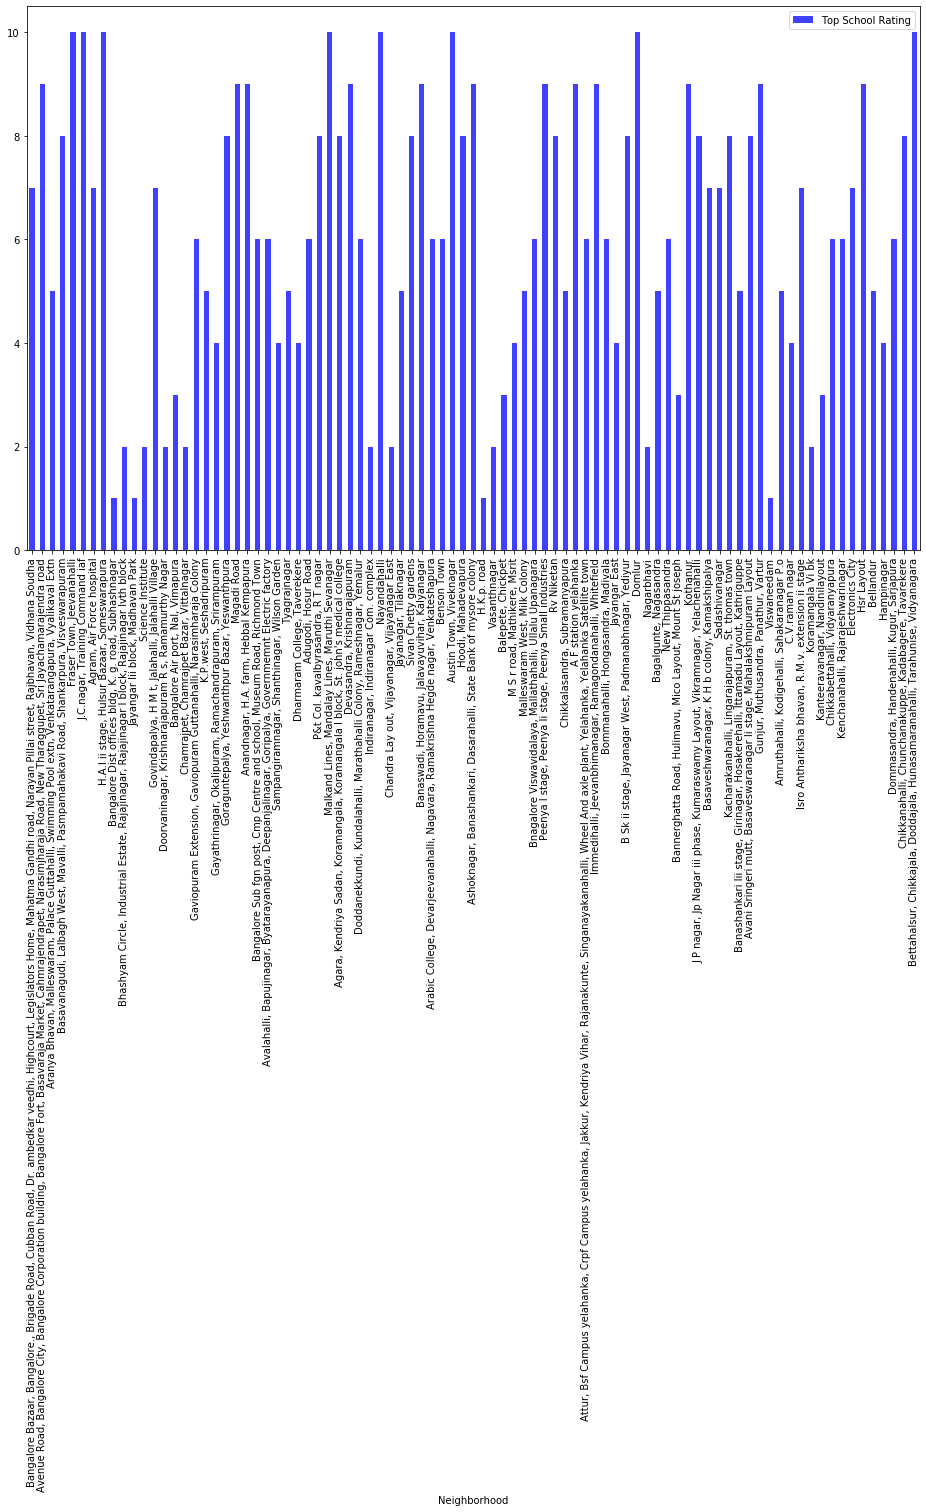

In [321]:
Bangalore_school_ratings.plot(kind='bar',figsize=(16,10),color='blue',alpha=0.75, y='Top School Rating')

<h3>Average school ratings for each cluster</h3>

In [322]:
cluster_ratings = Bangalore_school_ratings.groupby(['Clusters']).mean()

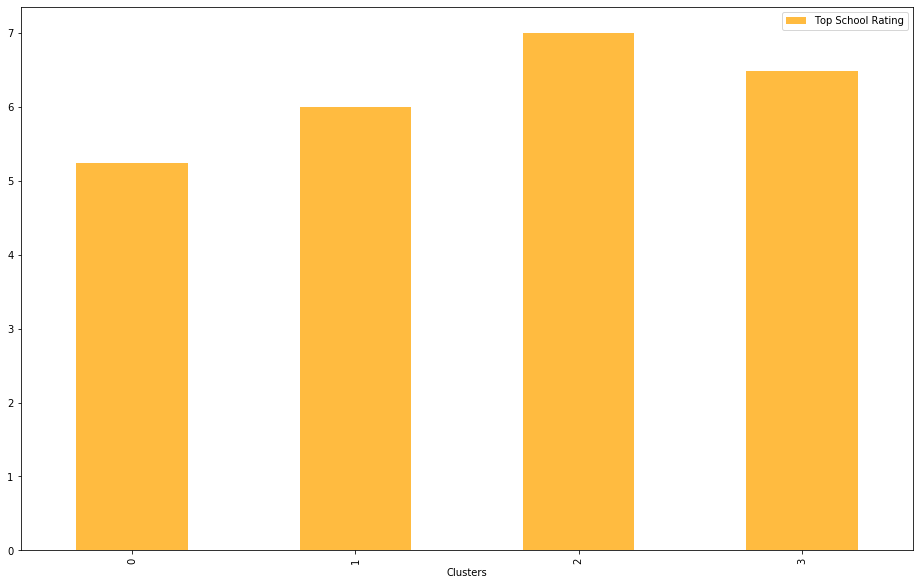

In [323]:
cluster_ratings.plot(kind='bar',figsize=(16,10),color='orange',alpha=0.75)

<h3>Average Rental Price of each Neighborhood</h3>

In [328]:
bangalore_avg_house_rental_price = pd.DataFrame({'Neighborhood':bangalore_merged["Neighborhood"],'Clusters':bangalore_merged['Cluster Labels'],
                                                'Avg rental price': [41007, 36472, 34031, 41797, 39831, 20546, 20645, 31162,
                                                                     24206, 42268, 28241, 42922, 40295, 25573, 47673, 31973,
                                                                     41469, 38600, 26641, 49629, 37826, 39671, 20644, 30645,
                                                                     27435, 28160, 29570, 49689, 29125, 47585, 40614, 28046,
                                                                     29911, 20718, 33976, 30725, 20259, 35567, 40603, 47450,
                                                                     39418, 38565, 44813, 41010, 48180, 44785, 20213, 23407,
                                                                     48096, 42071, 35511, 24899, 25141, 37521, 40469, 22712,
                                                                     24722, 27132, 24976, 35966, 23099, 29967, 28224, 20866,
                                                                     31332, 29845, 33670, 25911, 20501, 46748, 28313, 41361,
                                                                     47263, 40694, 46099, 48750, 23114, 37580, 22792,41489, 38600, 26641, 49629, 37826, 39671, 20644, 30645,
                                                                     ]})

In [329]:
bangalore_avg_house_rental_price.head()

,Neighborhood,Clusters,Avg rental price
0,"Bangalore Bazaar, Bangalore., Brigade Road, Cu...",3,41007
1,"Avenue Road, Bangalore City, Bangalore Corpora...",3,36472
2,"Aranya Bhavan, Malleswaram, Palace Guttahalli,...",3,34031
3,"Basavanagudi, Lalbagh West, Mavalli, Pasmpamah...",0,41797
4,"Fraser Town, Jeevanahalli",0,39831


In [330]:
bangalore_avg_house_rental_price.set_index('Neighborhood',inplace=True,drop=True)

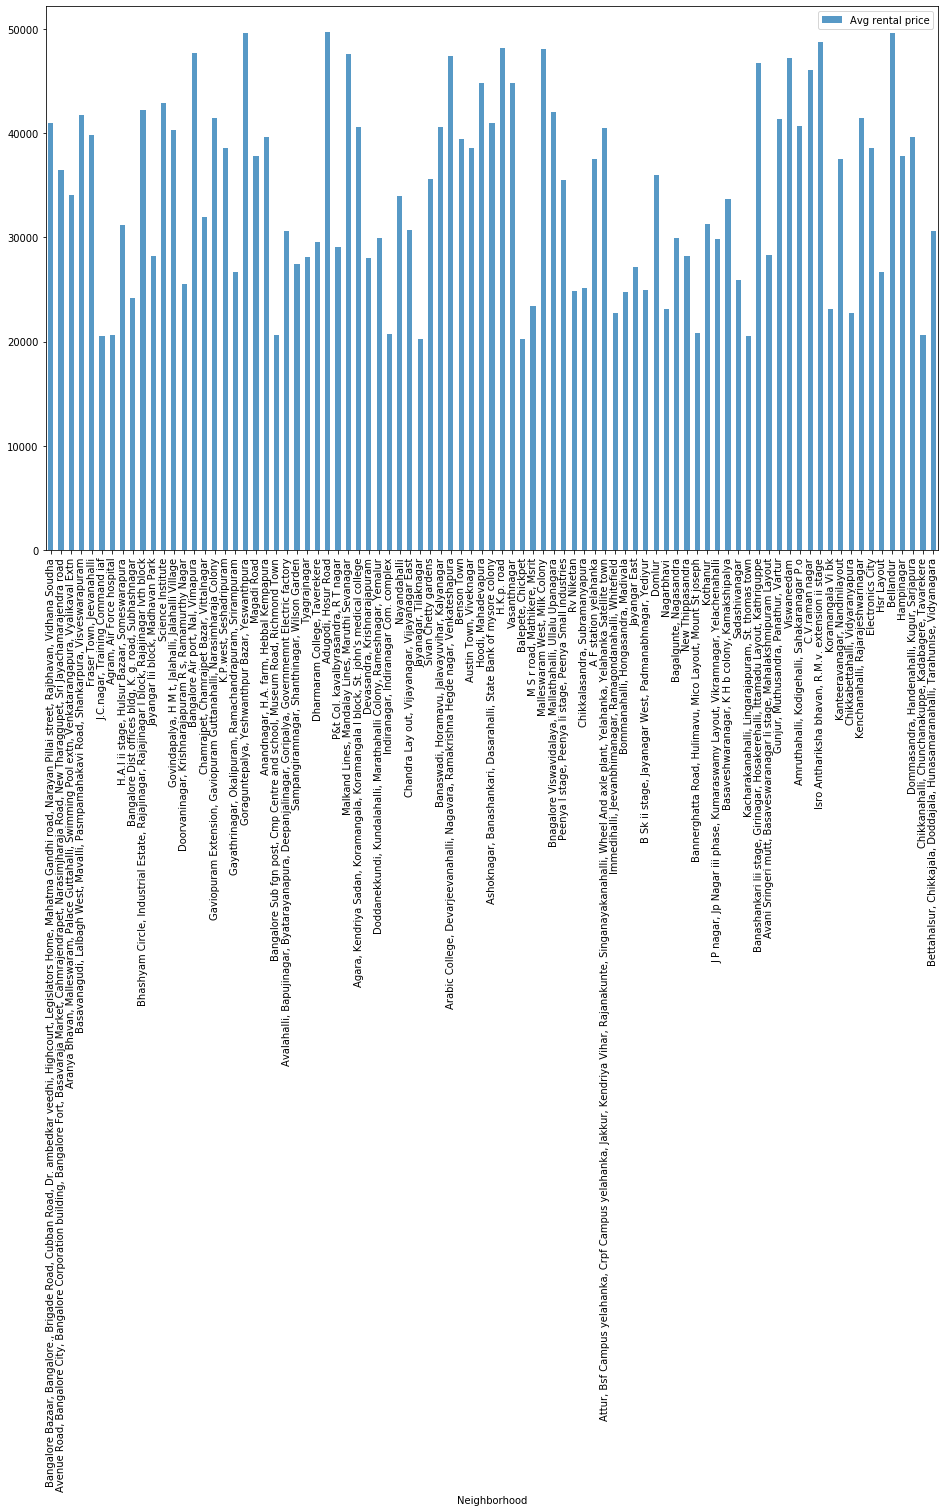

In [331]:
bangalore_avg_house_rental_price.plot(kind='bar',figsize=(16,10),alpha=0.75,y='Avg rental price')

<h3>Average Rental Price by Clusters</h3>

In [332]:
cluster_avg_rental = bangalore_avg_house_rental_price.groupby(['Clusters']).mean()

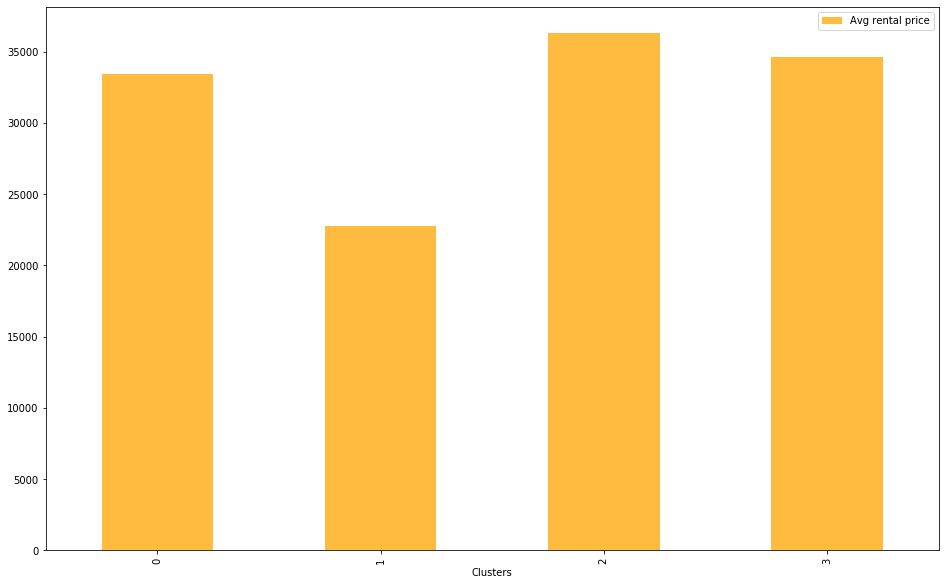

In [333]:
cluster_avg_rental.plot(kind='bar',figsize=(16,10),color='orange',alpha=0.75)

## 4. Results and Discussion <a name="results"></a>

Our analysis shows that there are great number of neighborhoods in Bangalore to choose based of availability of essentials and fairly good schools and affordable house rents.

Neighborhoods of Cluster 3 has good school ratings than the neighborhoods of cluster 0, although their average house rental prices are almost similar. Neighborhoods of cluster 3 also contains variety of venues with some of the most common venues include Cafe shops, parks, diner, design studios.

So neighborhoods of cluster 3 are good if a person is migrating to Bangalore and wants a neighborhood with similar area of interest as discussed. But one can always choose a different neighbor based on their area of interests and needs.

## 5. Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Neighborhoods in Bangalore with best facalities for a person migrating to Bangalore City.The location of each neighborhood was obtained using Geocoder Python package. The venues of each of the neighborhoods of Bangalore City was obtained using Foursquare API and analyzed to get the top 10 most common venues in each neighborhood.
The neighborhoods were then clustered to analyze similar neighborhoods. Then the observations were visualized inorder to make an informed decision.

Final decision on optimal neighborhood location will be made by individual based on specific characteristics of neighborhoods and locations, taking into consideration additional factors like attractiveness of each location (proximity to park or water), real estate availability, prices, social and economic dynamics of every neighborhood etc.